In [2]:
import csv
import ast
import re
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO

from matplotlib import pyplot as plt

In [122]:
def align_read(querystr,cigarstr,pattern=re.compile("[0-9]{0,10}[MDI]")):
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
#     output_str = "".join(["-" for i in range(cigar[1])])
    output_str = ""
    current_idx = 0
    for item in cigar_seq:
        if item[0]=="M":
            added_str = querystr[current_idx:current_idx+item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0]=="D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0]=="I":
            current_idx += item[1]
    return output_str
def cigarsfromsam(samfilepath):
    cigars = {}
    with open(samfilepath,"r") as samfile:
        for line in samfile:
            if line[0]=="@":
                next(samfile)
            else:
                splitline = line.split("\t")
                cigars[splitline[0]] = splitline[5]
    return cigars

def strsfromfasta(fastafilepath):
    queries = SeqIO.to_dict(SeqIO.parse(fastafilepath,"fasta"))
    queries = {key: str(val.seq) for key,val in queries.items()}
    return queries

def make_seg_dict(gfafile):
    segment_dict = {}
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                segment_dict[splitline[1]] = splitline[2][:-1]
    return segment_dict

def get_ref_intervals(gfafile):
    segment_dict = {}
    current_idx = 0
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                if "OFF" not in splitline[1]:
                    refstr = splitline[2][:-1]
                    strlen = len(refstr)
                    name = splitline[1]
                    if "ON" in name:
                        name=name[:-2]
                    segment_dict[name] = tuple((current_idx,current_idx+strlen))
                    current_idx += strlen
    return segment_dict
def align_read(querystr,cigarstr,pattern=re.compile("[0-9]{0,10}[MDI]")):
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
#     output_str = "".join(["-" for i in range(cigar[1])])
    output_str = ""
    current_idx = 0
    for item in cigar_seq:
        if item[0]=="M":
            added_str = querystr[current_idx:current_idx+item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0]=="D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0]=="I":
            current_idx += item[1]
    return output_str

def splitstr(instr,ref_intervals):    
    strassign = {key:instr[val[0]:val[1]] for key,val in ref_intervals.items()}
    return strassign

def slow_hamming_distance(s1, s2):
    if len(s1) != len(s2):
        print(s1,s2)
        raise ValueError("Strand lengths are not equal!")
    term_list = []
    for ch1,ch2 in zip(s1,s2):
        if ch1 == "N" or ch2 == "N":
            term_list.append(False)
        else:
            term_list.append(ch1 != ch2)
    result = sum(term_list)
    return result

def get_dict_dist(dict1,dict2):
    hamming_dict = {key:slow_hamming_distance(dict1[key],dict2[key]) for key in dict1.keys()}
    return hamming_dict

In [142]:
# ORIGINAL PATHS
R9_data = pd.read_csv("/home/de64/scratch/de64/sync_folder/2020-10-18_snakemake_2020-09-24_oDEPool3/output.tsv",delimiter="\t")
R10_data = pd.read_csv("/home/de64/scratch/de64/sync_folder/2020-10-18_snakemake_2020-10-14_lDE11_R10-3_merged/output.tsv",delimiter="\t")
ref_intervals = get_ref_intervals("/home/de64/scratch/de64/sync_folder/2020-10-18_snakemake_2020-10-14_lDE11_R10-3_merged/ref.gfa")

In [143]:
# R9_data = pd.read_csv("/home/de64/scratch/de64/2020-12-05_DAC/R9_output.tsv",delimiter="\t")
# R10_data = pd.read_csv("/home/de64/scratch/de64/2020-12-05_DAC/R10_output.tsv",delimiter="\t")
# ref_intervals = get_ref_intervals("./ref.gfa")

R9_barcodes = set(R9_data["barcode"].tolist())
R10_barcodes = set(R10_data["barcode"].tolist())

R9_only_barcodes = R9_barcodes-R10_barcodes
R10_only_barcodes = R10_barcodes-R9_barcodes
shared_barcodes = R10_barcodes&R9_barcodes
barcode_count_arr = np.array([len(R9_only_barcodes),len(R10_only_barcodes),len(shared_barcodes)])

R9_data = R9_data[R9_data["barcode"].isin(shared_barcodes)]
R10_data = R10_data[R10_data["barcode"].isin(shared_barcodes)]

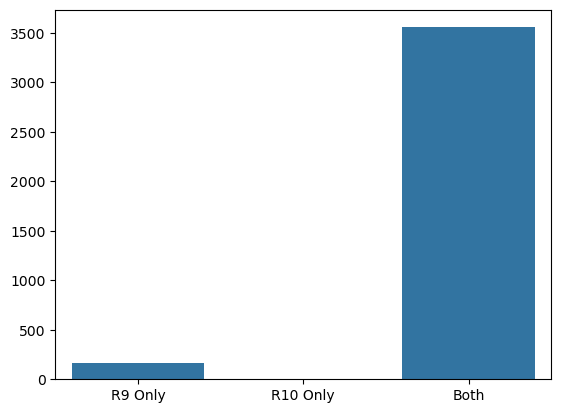

In [144]:
ax = sns.barplot(x=["R9 Only","R10 Only","Both"], y=barcode_count_arr)

In [145]:
bit_arr = np.array([list(item) for item in shared_barcodes]).astype(int)
bit_freq = np.mean(bit_arr,axis=0)

In [146]:
len(bit_freq)

27

In [147]:
bit_arr

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

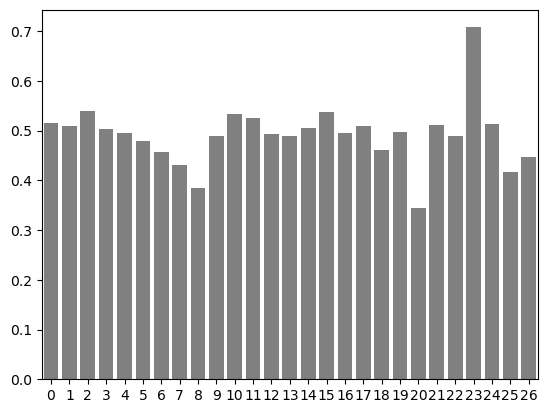

In [148]:
ax = sns.barplot(x=list(range(27)), y=bit_freq, color="grey")

In [149]:
both_on = bit_arr@bit_arr.T
both_off = (-bit_arr+1)@(-bit_arr.T+1)
ttl_match = both_on+both_off
np.fill_diagonal(ttl_match,100)

In [150]:
closest_match = np.min(ttl_match,axis=0)

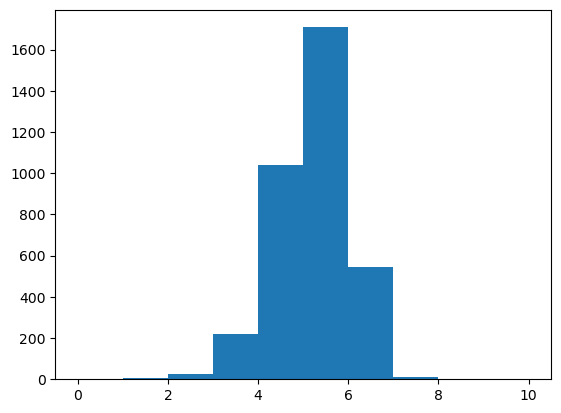

In [151]:
plt.hist(closest_match,range=(0,10))
plt.show()

In [152]:
np.sum(closest_match==1)

4

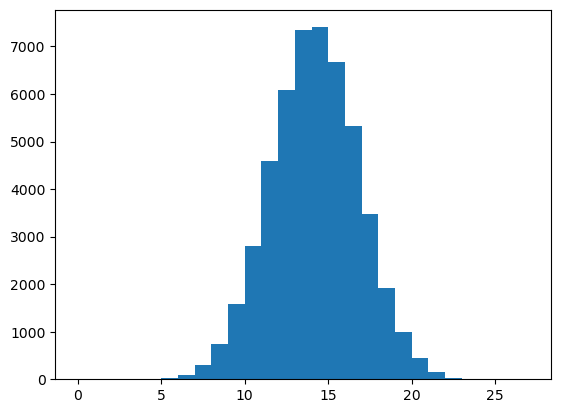

In [153]:
plt.hist(np.random.choice(ttl_match.flatten(),50000,replace=False),range=(0,27),bins=27)
plt.show()

In [154]:
aligned_cons = R9_data.apply(lambda x: align_read(x["consensus"],x["cigar"]), axis=1)
R9_data["aligned_cons"] = aligned_cons

aligned_cons = R10_data.apply(lambda x: align_read(x["consensus"],x["cigar"]), axis=1)
R10_data["aligned_cons"] = aligned_cons

split_ref = R9_data.apply(lambda x: splitstr(x["reference"],ref_intervals), axis=1)
split_align = R9_data.apply(lambda x: splitstr(x["aligned_cons"],ref_intervals), axis=1)
R9_data["split_ref"] = split_ref
R9_data["split_align"] = split_align

split_ref = R10_data.apply(lambda x: splitstr(x["reference"],ref_intervals), axis=1)
split_align = R10_data.apply(lambda x: splitstr(x["aligned_cons"],ref_intervals), axis=1)
R10_data["split_ref"] = split_ref
R10_data["split_align"] = split_align

R9_data["split_ref"] = R9_data["split_ref"].apply(lambda x: {key:val for key,val in x.items() if key=="GFP"}) ## This is a hack until I can repull the alignment data...then I'll add padding for the unaligned parts
R9_data["split_align"] = R9_data["split_align"].apply(lambda x: {key:val for key,val in x.items() if key=="GFP"}) ## This is a hack until I can repull the alignment data...

R10_data["split_ref"] = R10_data["split_ref"].apply(lambda x: {key:val for key,val in x.items() if key=="GFP"}) ## This is a hack until I can repull the alignment data...then I'll add padding for the unaligned parts
R10_data["split_align"] = R10_data["split_align"].apply(lambda x: {key:val for key,val in x.items() if key=="GFP"}) ## This is a hack until I can repull the alignment data...

hamm_ref = R9_data.apply(lambda x: get_dict_dist(x["split_align"],x["split_ref"]), axis=1)
R9_data["hamm_ref"] = hamm_ref
hamm_ref = R10_data.apply(lambda x: get_dict_dist(x["split_align"],x["split_ref"]), axis=1)
R10_data["hamm_ref"] = hamm_ref

dark_gfp = R9_data.apply(lambda x: slow_hamming_distance(x["split_align"]["GFP"][623:625],x["split_ref"]["GFP"][623:625]), axis=1)>0
R9_data["dark_gfp"] = dark_gfp
dark_gfp = R10_data.apply(lambda x: slow_hamming_distance(x["split_align"]["GFP"][623:625],x["split_ref"]["GFP"][623:625]), axis=1)>0
R10_data["dark_gfp"] = dark_gfp

R9_data["UMI"] = R9_data["split_align"].apply(lambda x: x["GFP"][925:940])
R10_data["UMI"] = R10_data["split_align"].apply(lambda x: x["GFP"][925:940])

In [155]:
R9_ground_truth_data = R9_data[R9_data["subsample"]==200]
R9_ground_truth_lookup = dict(zip(R9_ground_truth_data["barcodeid"],R9_ground_truth_data["dark_gfp"]))

R9_data["GFP Call"] = R9_data.apply(lambda x: x["dark_gfp"]==R9_ground_truth_lookup[x["barcodeid"]],axis=1)

R10_ground_truth_data = R10_data[R10_data["subsample"]==200]
R10_ground_truth_lookup = dict(zip(R10_ground_truth_data["barcodeid"],R10_ground_truth_data["dark_gfp"]))

R10_data["GFP Call"] = R10_data.apply(lambda x: x["dark_gfp"]==R10_ground_truth_lookup[x["barcodeid"]],axis=1)

In [156]:
R9_subsample_group = R9_data.groupby("subsample")
R10_subsample_group = R10_data.groupby("subsample")

R9_GFP_call_curve = 1-R9_subsample_group.aggregate({'GFP Call': 'mean'})
R10_GFP_call_curve = 1-R10_subsample_group.aggregate({'GFP Call': 'mean'})

R9_GFP_q_scores = -10*np.log10(R9_GFP_call_curve)
R10_GFP_q_scores = -10*np.log10(R10_GFP_call_curve)

/home/de64/micromamba/envs/nanopore/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


### UMI Error

In [157]:
R9_ground_truth_umi_lookup = dict(zip(R9_ground_truth_data["barcodeid"],R9_ground_truth_data["UMI"]))
R9_data["UMI Errors"] = R9_data.apply(lambda x: slow_hamming_distance(x["UMI"],R9_ground_truth_umi_lookup[x["barcodeid"]]),axis=1)
R9_data["UMI Error Rate"] = R9_data["UMI Errors"]/15
R9_subsample_group = R9_data.groupby("subsample")
R9_UMI_call_curve = R9_subsample_group.aggregate({'UMI Error Rate': 'mean'})

R10_ground_truth_umi_lookup = dict(zip(R10_ground_truth_data["barcodeid"],R10_ground_truth_data["UMI"]))
R10_data["UMI Errors"] = R10_data.apply(lambda x: slow_hamming_distance(x["UMI"],R10_ground_truth_umi_lookup[x["barcodeid"]]),axis=1)
R10_data["UMI Error Rate"] = R10_data["UMI Errors"]/15
R10_subsample_group = R10_data.groupby("subsample")
R10_UMI_call_curve = R10_subsample_group.aggregate({'UMI Error Rate': 'mean'})

In [158]:
R9_GFP_call_curve

,GFP Call
subsample,
5,0.037131
10,0.012940
15,0.006188
20,0.004219
25,0.005626
50,0.001688
200,0.000000


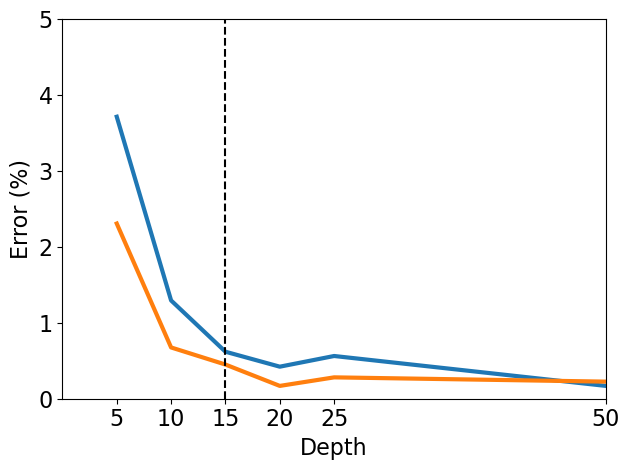

In [159]:
plt.plot(R9_GFP_call_curve*100,linewidth=3.,label="R9.4.1")
plt.plot(R10_GFP_call_curve*100,linewidth=3.,label="R10.3.1")
plt.axvline(15,color="C1",ls="--",c="black")
plt.ylim(0.,5.)
plt.xlim(0,50)
plt.xticks([5,10,15,20,25,50],fontsize=16)
plt.yticks([0.,1.,2.,3.,4.,5.],fontsize=16)
plt.xlabel("Depth",fontsize=16)
plt.ylabel("Error (%)",fontsize=16)
plt.tight_layout()
# plt.savefig("./Figure_1.png",dpi=150)

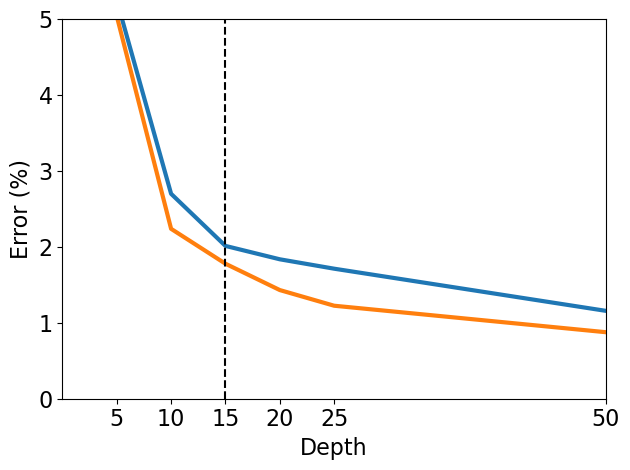

In [160]:
plt.plot(R9_UMI_call_curve*100,linewidth=3.,label="R9.4.1")
plt.plot(R10_UMI_call_curve*100,linewidth=3.,label="R10.3.1")
plt.axvline(15,color="C1",ls="--",c="black")
plt.ylim(0.,5.)
plt.xlim(0,50)
plt.xticks([5,10,15,20,25,50],fontsize=16)
plt.yticks([0.,1.,2.,3.,4.,5.],fontsize=16)
plt.xlabel("Depth",fontsize=16)
plt.ylabel("Error (%)",fontsize=16)
plt.tight_layout()
# plt.savefig("./Figure_1.png",dpi=150)

In [168]:
bitlist = ["BIT" + str(i) for i in range(27)]
bit_mismatch_dict = {}
for bit in bitlist:
    mismatch_list = data.apply(lambda x: x["hamm_ref"][bit], axis=1).values
    bit_mismatch_dict[bit] = mismatch_list

In [169]:
bit_mismatch_dict

{'BIT0': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT1': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT2': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT3': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT4': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT5': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT6': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT7': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT8': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT9': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT10': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT11': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT12': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT13': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT14': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT15': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT16': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT17': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT18': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT19': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT20': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT21': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT22': array([0, 0, 0, ..., 0, 0, 0]),
 'BIT23': array([0, 0, 0, ..., 0, 0, 0]),
 '

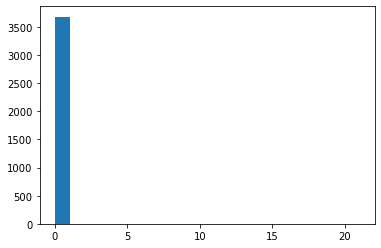

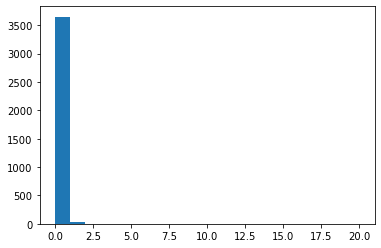

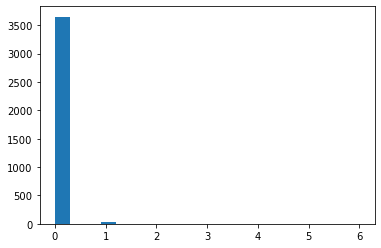

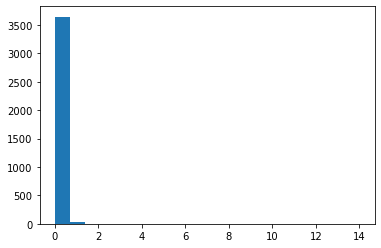

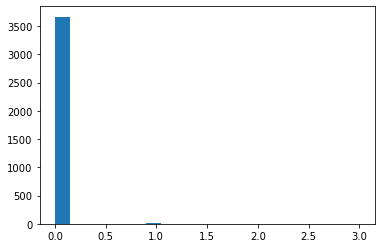

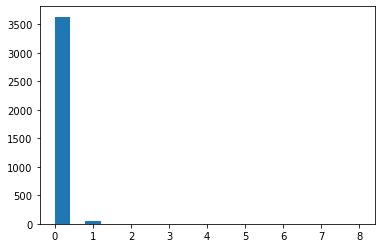

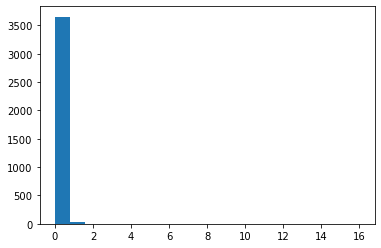

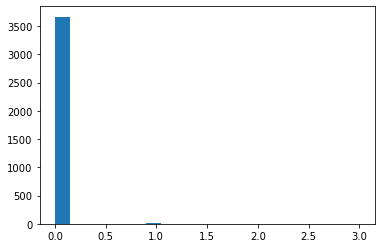

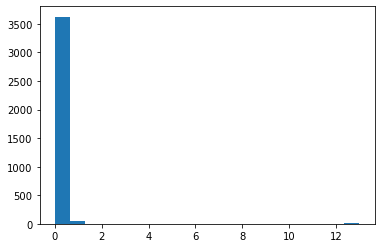

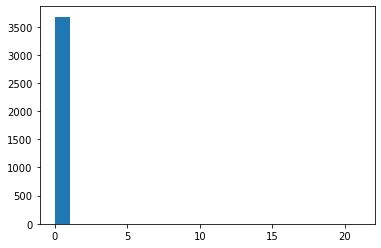

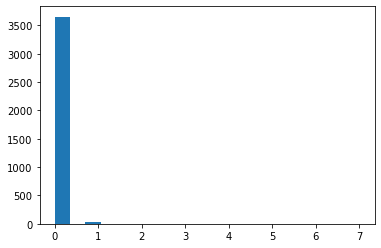

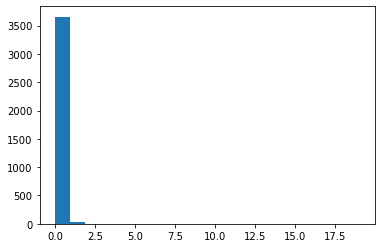

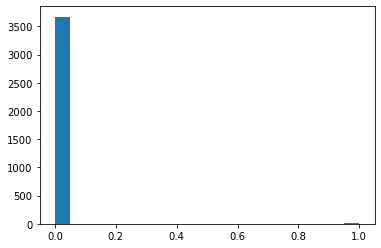

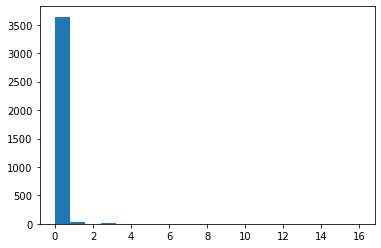

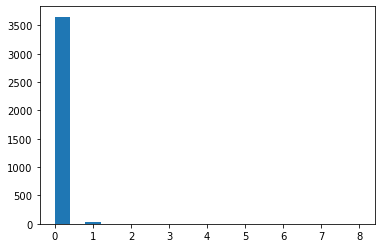

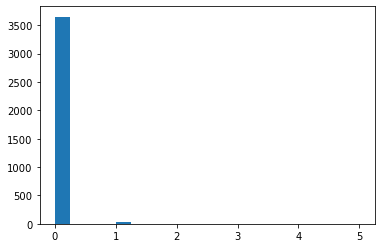

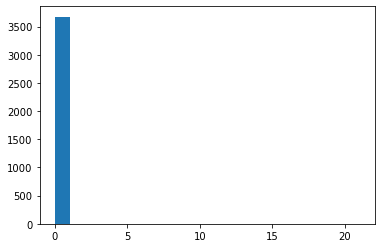

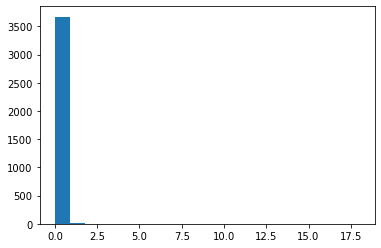

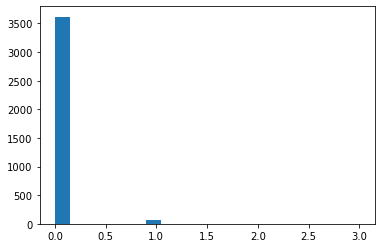

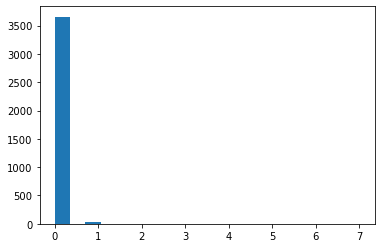

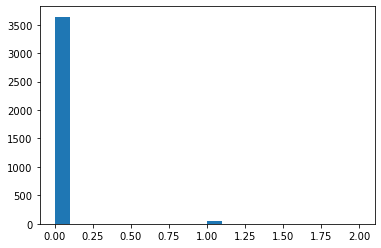

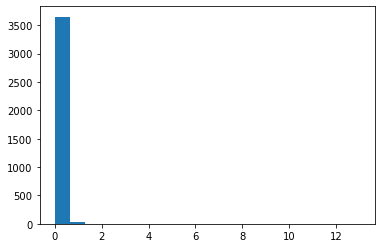

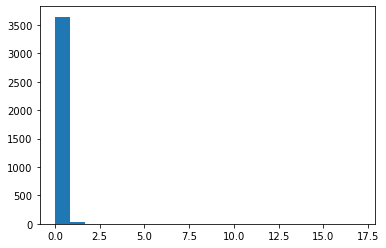

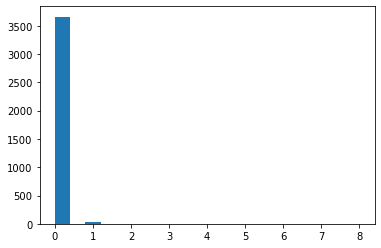

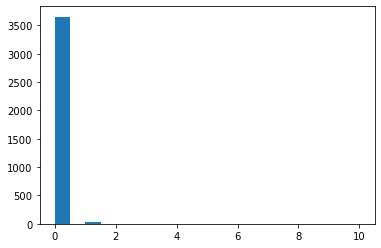

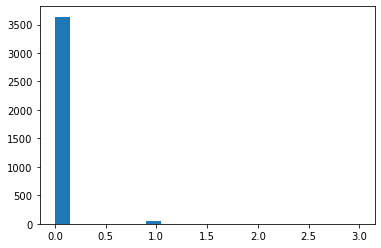

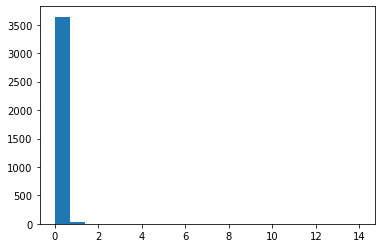

In [170]:
from matplotlib import pyplot as plt

for key in bit_mismatch_dict.keys():
    plt.hist(bit_mismatch_dict[key],bins=20)
    plt.show()

In [171]:
miscalls = data.apply(lambda x: x["hamm_ref"]['BIT26'], axis=1).values>5

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

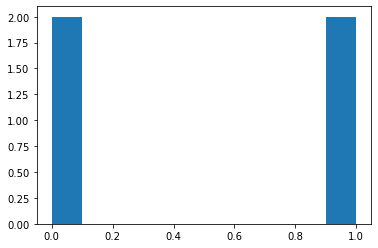

In [172]:
plt.hist([int(item[26]) for item in data[miscalls]["barcode"]])

(array([2026.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1659.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

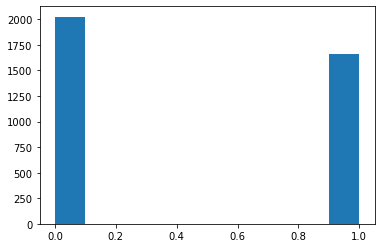

In [173]:
plt.hist([int(item[26]) for item in data[~miscalls]["barcode"]])

(array([2028.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1661.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

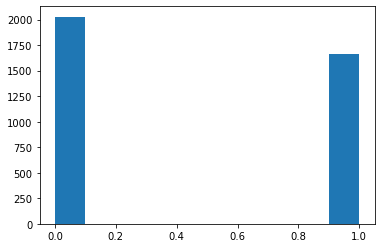

In [174]:
plt.hist([int(item[26]) for item in data["barcode"]])

So the last bit is always called as 0; fixed. was no newline at the end of the .gaf file

In [203]:
list(np.random.choice([0,1,2],size=3,replace=False))

[0, 1, 2]

In [2]:
import csv
import numpy as np
import os

from matplotlib import pyplot as plt

In [10]:
inpathlist = ["/home/de64/scratch/de64/2020-10-18_snakemake_2020-09-24_oDEPool3/graph_output/" + item for item in os.listdir("/home/de64/scratch/de64/2020-10-18_snakemake_2020-09-24_oDEPool3/graph_output") if item[-3:] == "tsv" and item[:4]=="read"]

In [12]:
### Get Barcode Histogram ###

barcode_dict = {}
for filepath in inpathlist:    
    with open(filepath, "r") as infile:
        next(infile)
        for line in infile:
            data = line.split("\t")
            barcode_dict[data[0]] = data[1]

In [16]:
barcode_arr = np.array(list(barcode_dict.values()))
unique, counts = np.unique(barcode_arr, return_counts=True)=

In [26]:
vmin,vmax = (2,np.max(counts[counts]))
nbins = vmax-vmin

In [28]:
nbins

5078

1277.0

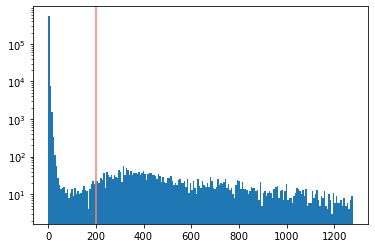

In [40]:
vmin,vmax = (0,int(np.percentile(counts,99.9)))
nbins = min(200,vmax-vmin)

plt.hist(counts,range=(vmin,vmax),bins=nbins)
plt.yscale('log')
plt.axvline(200,color="salmon")
plt.show()

In [67]:
data = pd.read_csv("/home/de64/scratch/de64/2020-10-18_snakemake_2020-09-24_oDEPool3/graph_output/inv_codebook.tsv",delimiter="\t")

In [49]:
data["barcodeid"]

0          0
1          1
2          2
3          3
4          4
        ... 
3718    3718
3719    3719
3720    3720
3721    3721
3722    3722
Name: barcodeid, Length: 3723, dtype: int64

In [61]:
test = data["readlist"]

In [77]:
inv_barcode_codebook = {}
for _,row in data.iterrows():
    inv_barcode_codebook[int(row['barcodeid'])] = ast.literal_eval(row['readlist'])

In [79]:
inv_barcode_codebook[0]

['a34525e8-c6f5-426c-8c65-75dcba4c148c',
 '683adc73-2b80-4f89-bfc0-d7d3835e16a0',
 '62ceb17d-fe23-4db0-8710-59d06eceb5dd',
 '273f62c7-6c03-4650-9d9e-95333448d860',
 'a03fc8d4-c3d4-4bef-8818-f55c46750d6a',
 '003e0bea-2622-4c34-96ac-0e3e061374ed',
 '28002711-e7a0-46ad-b6a3-34c0ff4e7845',
 'dd682a90-8616-4f91-a0d4-dcf406521591',
 '3744ab47-5a14-491e-87b1-8b7fa3425418',
 '40c40c3e-5c9b-4477-b677-7f567c9cab3b',
 '6eb0d92f-2a50-4dc7-bf7c-b1dfdbe4f70a',
 'a381933c-2c3a-4a42-89c6-ca4398961461',
 '3d089c9d-549e-479c-8e35-b79bb309a7f4',
 '71945236-b364-4a46-9f91-7b8b8e032f77',
 '4b9f4021-638d-4d61-8d32-c0c5ed22d526',
 '0c06352b-95a0-4365-ba23-aa20b0bb5e49',
 'fa0d4a45-c396-4892-9fdd-0391bb9297d5',
 '107c2096-6c20-4744-a6ee-1873f5b43530',
 'e1dc495e-de08-4136-b402-5ccaff1146a4',
 'beac6f90-9a47-45f6-ae71-c13eaeab9776',
 'e6765dc9-434c-456e-a643-12beacd64b89',
 '4ccb21dc-e26c-4747-88d0-cdbafed468a8',
 '1d08381f-e8a0-400a-a101-502cc7119961',
 'd165bea2-200e-4ced-b14b-e8a1ac42382b',
 '6c7a41c8-b458-

In [84]:
d = {1:2}
d.update({3:4})

In [85]:
d

{1: 2, 3: 4}

In [90]:
print("making fastq dict")
record_dict_list = [{1:2},{3:4},{5:6}]
record_dict = {}
for i in range(len(record_dict_list)):
    subdict = record_dict_list[i]
    record_dict.update(subdict)
    del subdict
    record_dict_list[i] = None
del record_dict_list
print("finished making fastq dict")


making fastq dict
finished making fastq dict


In [92]:
record_dict

{1: 2, 3: 4, 5: 6}

In [1]:
import pandas as pd

In [5]:
data = pd.read_csv("/home/de64/scratch/de64/2020-10-18_snakemake_2020-09-24_oDEPool3/output.tsv",delimiter="\t")

In [7]:
test = data[data["subsample"]==200]

In [8]:
test

,Unnamed: 0,barcodeid,barcode,consensus,reference,cigar,subsample
26061,0,0,000000000000001111100110001,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1695M,200
26062,1,1,000000000001010110010111111,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1608M1I87M,200
26063,2,2,000000000010000101000001011,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1695M,200
26064,3,3,000000000100001010001111001,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1115M1I580M,200
26065,4,4,000000000101101110110011111,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1695M,200
...,...,...,...,...,...,...,...
29779,3718,3718,111111110100111001011011100,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1695M,200
29780,3719,3719,111111110101001100001100111,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1324M1D370M,200
29781,3720,3720,111111110110000110100011010,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1695M,200
29782,3721,3721,111111110110011000010100000,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1695M,200
